# - This notebook was used to see how well the best model performs on the experimental images -

# Imports and data loading

In [6]:
######################################################################
############################# Imports ################################
######################################################################
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import cv2
import random

import numpy as np
import numpy.ma as ma
import pandas as pd
import shutil
import os

from scipy import constants
from scipy import misc
from scipy.ndimage import gaussian_filter

from abtem import __version__
from abtem import *

from ase.io import read
from ase.cluster import wulff_construction
from ase import Atoms
import ase.data

from PIL import Image
from skimage import data
from skimage import filters
from skimage import exposure
from skimage.filters import gaussian

# Definitions of important functions

In [5]:
# Locala normalization of brightness in image    
def local_normalize(images, sigma1, sigma2):
    if len(images.shape)==4:
        for i in range(images.shape[0]):
            
            B=np.zeros_like(images[0,:,:,0])
            S=np.zeros_like(images[0,:,:,0])
            for j in range(images.shape[3]):
                B+=gaussian_filter(images[i,:,:,j],sigma1)
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] - B/images.shape[3]
            
            for j in range(images.shape[3]):
                S+=np.sqrt(gaussian_filter(images[i,:,:,j]**2, sigma2))
            
            for j in range(images.shape[3]):
                images[i,:,:,j] = images[i,:,:,j] / (S/images.shape[3])
    else:
        images = (images-np.min(images))/(np.max(images)-np.min(images))
        images = images - gaussian(images,sigma1,multichannel=False)
        images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))
        
    return images

# Function that rescales the array values to be in range 0,255
def rescale(arr):
    min_val = np.amin(arr)
    max_val = np.amax(arr)
    val_range = max_val - min_val
    return 255 * (arr - min_val) / val_range

# Function that creates a custom sized circle mask at given h,w
def create_circular_mask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    mask = dist_from_center <= radius
    return mask

# Load images


In [ ]:
def load_image(path_to, name):
    image = Image.open(path_to)
    
    image_arr = np.array(image)
     
    # remove dimensions
    image_arr = image_arr.astype(float)
    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]
    image_arr /= 255
    
    # make image black&white 
    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)
    
    # Background removal
    g_filter = gaussian_filter(image_arr, sigma=30)
    img = image_arr - g_filter
    
    # Local normalization
    local_norm = local_normalize(img, 30, 30)
    image_center = np.unravel_index(np.argmax(g_filter, axis=None), g_filter.shape)
    image_center_arr = np.array(image_center)
    inner_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 110)
    visible_mask = create_circular_mask(600 ,800 ,
                                      center = image_center_arr, radius = 250)
    visible_mask = np.logical_xor(visible_mask, inner_mask)

    # Apply mask
    masked = ma.masked_array(image_arr, ~visible_mask)    
    result = masked[image_center[0]-250: image_center[0]+250, image_center[1]-250: image_center[1]+250]
    r2 = np.where(~result.mask, result.data, 0)
    print(name)
    mimg.imsave(name, r2, cmap = 'gray')

In [ ]:
l = os.listdir("Exp")

In [ ]:
image_l = np.zeros((len(l)-2,1, 500, 500))
c = 0
load_image("Exp/{}".format(l[0]), "{}.png".format(l[0].split(".")[0]))
load_image("Exp/{}".format(l[4]), "{}.png".format(l[4].split(".")[0]))
load_image("Exp/{}".format(l[5]), "{}.png".format(l[5].split(".")[0]))

# Experiments with automating the load of models

In [2]:
# # Neural network imports
import keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import CustomObjectScope
import keras.backend as K
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.models import Model
from keras.models import load_model 
from keras.utils import Sequence
from keras.utils import load_img
from keras.callbacks import *

2023-01-29 16:34:46.599203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 16:34:48.374972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /zhome/ab/7/153983/project/venv/lib/python3.10/site-packages/cv2/../../lib64:/appl/cudnn/v8.3.2.44-prod-cuda-11.5/lib:/appl/cuda/11.6.0/lib64:/appl/python/3.10.7/lib:/appl/gcc/11.3.0-binutils-2.38/lib64:/appl/gcc/11.3.0-binutils-2.38/lib:/lsf/10.1/linux3.10-glibc2.17-x86_64/lib
2023-01-29 16:34:48.375538: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

In [3]:
######################################################################    
########################## Loss functions ############################    
###################################################################### 

  
def abs_loss_function(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    return tf.math.reduce_mean(minimum_from_two, axis=-1)

def sqrt_abs_min_loss(y_true, y_pred):   
    abs_diff = K.abs(y_true - y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(tf.ones_like(y_true) - abs_diff )   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed) 
    min_sq = tf.math.sqrt(minimum_from_two)
    return tf.math.reduce_mean(min_sq, axis=-1) 

def smart_sqrt_abs_min_loss(y_true, y_pred):  
    punished_y_pred = tf.where((y_pred<0)|(y_pred>1), 2.0 + K.abs(y_pred), y_pred)
    abs_diff = K.abs(y_true - punished_y_pred)
    ones = tf.ones_like(y_true)
    abs_diff_reversed = K.abs(ones - abs_diff)   
    minimum_from_two = tf.math.minimum(abs_diff, abs_diff_reversed)     
    return tf.math.reduce_mean(minimum_from_two, axis=-1) 
############################# For debugging ####################################
#     print("_________________ 1 __________________")
#     print(abs_diff_reversed.numpy())
#     print("_________________ 2 __________________")
#     print(abs_diff.numpy())

In [4]:
######################################################################    
##################### Loading a model from a file ####################    
###################################################################### 
with CustomObjectScope({'smart_sqrt_abs_min_loss': smart_sqrt_abs_min_loss}):
    model = keras.models.load_model('Exp/RMSprop_smart_sqrt_abs_min_loss_0001_model_m_.h5')

2023-01-29 16:34:58.246055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-29 16:34:59.090831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14584 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:af:00.0, compute capability: 7.0


In [5]:
def predict_yhat(t):
    data = load_img(path = t, grayscale = True)
    data = tf.keras.utils.img_to_array(data, data_format="channels_last", dtype="float32")
    data /= 255
    data.shape = (1,) + data.shape
    yhat = model.predict(data)
    return yhat*90

In [8]:
predict_yhat("Exp/P14-R.png")

1/1 [==============================] - 0s 26ms/step


array([[46.501705, 37.342793, 50.433376]], dtype=float32)

In [9]:
predict_yhat("Exp/P15-R.png")

1/1 [==============================] - 0s 22ms/step


array([[49.390095, 35.54336 , 48.65813 ]], dtype=float32)

In [10]:
predict_yhat("Exp/P16-R.png")

1/1 [==============================] - 0s 22ms/step


array([[51.633633, 45.85486 , 53.57849 ]], dtype=float32)

In [2]:
# Function to simulate an image
def simulate_image(phi1 = 0, 
                   Phi = 0, 
                   phi2 = 0, 
                   path = "Images",
                   atom_nr = 32000, 
                   gridpoints = 8192,
                   dpi_val = 217, 
                   power_ilum = 0.25):
    
    center_type = 'cop' 
    surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)] # Nanoparticle facets # ASK
    esurf = [1.0, 1.1, 0.9] # Relative surface energies # ASK
    size = atom_nr # Target number of atoms
    atoms = Atoms(wulff_construction('Au', surfaces, esurf, size, 'fcc', rounding='above')) # ASK
    atoms.euler_rotate(phi1, Phi, phi2, center = center_type)
    atoms.center(vacuum=5.) 
    atoms.center(vacuum=2., axis=2) 
    
    angle = 2*4.5e-3
    defocus = 40/np.sin(angle)

    mass = ase.data.atomic_masses[ase.data.atomic_numbers['Au']]
    TD = 165  # Kittel
    T = 300
    U_squared = (3 * constants.hbar**2 / (2 *  mass * ase.units._amu * constants.k * TD)
                 * (1/4 + T / TD))
    sigmas = {'Au': np.sqrt(U_squared) * 1e10} # standard deviations of thermal vibrations
    num_configs = 10 # number of frozen phonon configurations

    frozen_phonons = FrozenPhonons(atoms, num_configs=num_configs, sigmas=sigmas)

    for i,config in enumerate(frozen_phonons):

        potential = Potential(config, 
                              gpts=gridpoints, 
                              slice_thickness=0.5, 
                              device='gpu',
                              #storage='cpu',
                              precalculate=False,
                              parametrization='kirkland', 
                              projection='infinite') # ASK

        probe = Probe(sampling=potential.sampling,
            device='gpu',
            semiangle_cutoff=1000*angle,
            extent=potential.extent,
            defocus=defocus,
            energy=30000 # acceleration voltage in eVhttp://localhost:8080/notebooks/Kikuchi.ipynb#
        )
        positions = (45, 45)

        exit_wave = probe.multislice(positions, potential)
        cbed_diffraction_pattern = exit_wave.diffraction_pattern(block_zeroth_order=0)

        if (i==0):
            summedImage = cbed_diffraction_pattern.array
        else:
            summedImage += cbed_diffraction_pattern.array


    cbed_diffraction_pattern.array[:] = summedImage/num_configs

    energy = probe.energy
    del probe

    if True:
        exit_wave._array = exit_wave._array.get()
        exit_wave._device = 'cpu'

    ax, im = cbed_diffraction_pattern.show(power = power_ilum)

    plt.axis('off')
     
    if not os.path.exists(path):
        os.makedirs(path)
    
    image_name = '{}/{}'.format(path, "{}_{}_{}.png".format(phi1,Phi,phi2))
    plt.savefig(image_name, bbox_inches='tight', dpi=dpi_val)
    return image_name

# generates a final image
def generate_donut(phi1 = 0, 
                   Phi = 0, 
                   phi2 = 0, 
                   path = "Images",
                   mask_enabled = True):
    
    # generate the image and save it into a file
    image_name = simulate_image(phi1=phi1, Phi=Phi, phi2=phi2, path = path)
    
    # Open file with generated image and save it
    image = Image.open(image_name)
    image_arr = np.array(image)
    
    # make image black&white and then transform into 800x600 array of floats
    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]
        
    image_arr = image_arr.astype(float)
    image_arr /= 255
    
    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)
    image_arr = image_arr[21+100:821-100, 22:822]
    
    # Background removal
    g_filter = gaussian_filter(image_arr, sigma=30)
    img = image_arr - g_filter
    
    # Local normalization
    local_norm = local_normalize(img, 30, 30)
    
    if mask_enabled:
        # Creates a donut shaped mask to show only important data
        image_center = np.unravel_index(np.argmax(g_filter, axis=None), g_filter.shape)
        image_center_arr = np.array(image_center)
        inner_mask = create_circular_mask(g_filter.shape[0] ,g_filter.shape[1] ,
                                          center = image_center_arr, radius = 100)
        visible_mask = create_circular_mask(g_filter.shape[0] ,g_filter.shape[1] ,
                                          center = image_center_arr, radius = 250)
        visible_mask = np.logical_xor(visible_mask, inner_mask)

        # Apply mask
        image_arr_masked = ma.masked_array(local_norm, ~visible_mask)
    
        # Save the resulting image
        mimg.imsave(image_name, image_arr_masked, cmap = 'gray')
    else:
         # Save the resulting image
        mimg.imsave(image_name, local_norm, cmap = 'gray')

Multislice: 100%|█████████████████████████████████████████████████████████████████████| 208/208 [00:08<00:00, 23.93it/s]
/tmp/ipykernel_13768/126751053.py:21: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images - gaussian(images,sigma1,multichannel=False)
/tmp/ipykernel_13768/126751053.py:22: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))


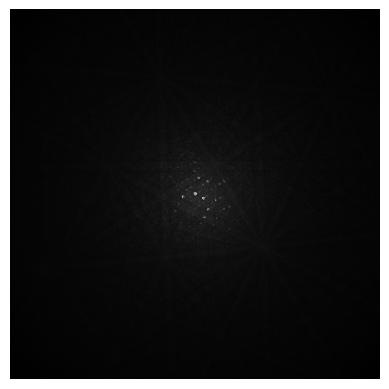

In [14]:
generate_donut(phi1=51.633633, Phi=45.85486, phi2=53.57849, path = "Exp", mask_enabled = False )

/tmp/ipykernel_13768/126751053.py:21: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images - gaussian(images,sigma1,multichannel=False)
/tmp/ipykernel_13768/126751053.py:22: FutureWarning: `multichannel` is a deprecated argument name for `gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  images = images / np.sqrt(gaussian(images**2, sigma2,multichannel=False))


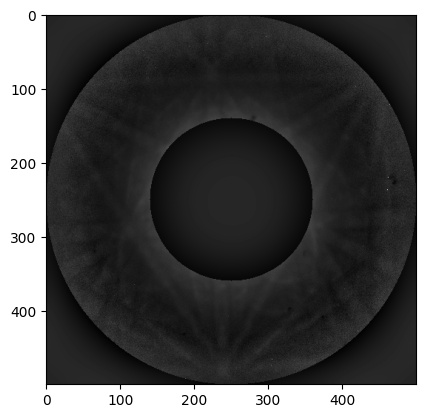

In [12]:
def load_image2(path_to):
    image = Image.open(path_to)
    
    image_arr = np.array(image)
     
    # remove dimensions
    image_arr = image_arr.astype(float)
    if image_arr.shape[-1] == 4:
        image_arr = image_arr[:,:,:-1]
    image_arr /= 255
    
    # make image black&white 
    if len(image_arr.shape) == 3:
        weights = np.array([1, 1, 1])
        image_arr = np.dot(image_arr, weights)
    
    # Background removal
    g_filter = gaussian_filter(image_arr, sigma=30)
    img = image_arr - g_filter
    
    # Local normalization
    local_norm = local_normalize(img, 30, 30)
    plt.imshow(local_norm, cmap = "gray")
    
load_image2("Exp/P16-R.png")